## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

### Imports

In [195]:
# Libraries
import cv2
import glob
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
import sklearn

from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Other
%matplotlib inline

### Parameters

In [634]:
# Sample Images
test_images = glob.glob('test_images/*.jpg')
n_test_images = int(len(test_images))
    
#test_img_path = 'test_images/straight_lines1.jpg'
#test_img_path = 'test_images/straight_lines2.jpg'
#test_img_path = 'test_images/test1.jpg'
#test_img_path = 'test_images/test2.jpg'
#test_img_path = 'test_images/test3.jpg'
#test_img_path = 'test_images/test4.jpg'
#test_img_path = 'test_images/test5.jpg'
#test_img_path = 'test_images/test6.jpg'

# Mask
img_w=1280
img_h=720
src = np.float32([(595, 450), # top left
                  (689, 450), # top right
                  (216, 719), # bottom left
                  (1111, 719)]) # bottom right
dst = np.float32([(320, 0), # top left
                  (img_w - 320, 0), # top right
                  (320 , img_h), # bottom left
                  (img_w - 320, img_h)]) # bottom right
src_x = [src[0][0], src[1][0], src[3][0], src[2][0], src[0][0]]
src_y = [src[0][1], src[1][1], src[3][1], src[2][1], src[0][1]]
dst_x = [dst[0][0], dst[1][0], dst[3][0], dst[2][0], dst[0][0]]
dst_y = [dst[0][1], dst[1][1], dst[3][1], dst[2][1], dst[0][1]]
    
# Variables
toggle = 1

### Classes (IN PROGRESS)

In [197]:
# Define a class to maintain all processed versions of the same sample
class Image():
    def __init__(self):
        # all image variants, following pipeline
        self.orig = None
        self.undst = None
        self.gray = None
        self.warp = None
        self.hls = None
        self.hsv = None
        self.s_binary = None
        self.sxbinary = None
        self.color_binary = None
        self.combined_binary = None
        # 

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

### Helper Functions

In [500]:
# apply distortion correction
def undistort(img):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    return undst

# apply warping correction
def unwarp(img, src, dst, mask='off'):
    h, w = img.shape[:2]
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    unwarp = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)
    return unwarp, Minv
       
# visualize an image in a binarized coloration
def binarize(img, thresh_min=150, thresh_max=255):
    # convert to grayscale if not already
    if len(img.shape)==3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    binary_output = np.zeros_like(img)
    binary_output[(img>=thresh_min) & (img<=thresh_max)] = 1
    return binary_output
    
# apply sobel absolute threshold
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # and take the absolute value
    if orient=='x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient=='y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # Return the binary image
    return binary_output

# apply sobel magnitude threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return the binary image
    return binary_output

# apply sobel directional threshold
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output

# combine two binary images with an AND operation
def combined_binary(img1, img2, oper='AND'):
    # ensure that both images are binarized
    bin1 = binarize(img1/(np.max(img1)-np.min(img1)) * 255)
    bin2 = binarize(img2/(np.max(img2)-np.min(img2)) * 255)
    combined_output = np.zeros_like(img1)
    if (oper=='AND'):
        combined_output[(bin1==1) & (bin2==1)] = 1
    if (oper=='OR'):
        combined_output[(bin1==1) | (bin2==1)] = 1
    return combined_output

# image processing pipeline
def pipeline(img, step=3):
    step1 = undistort(img)
    step2, Minv = unwarp(step1, src, dst)
    step3a1 = cv2.cvtColor(step2, cv2.COLOR_RGB2HLS)[:,:,2]
    step3a2 = cv2.cvtColor(step2, cv2.COLOR_RGB2Lab)[:,:,0]
    step3a = combined_binary(step3a1, step3a2, 'AND')
    step3b1 = abs_sobel_thresh(step2, thresh_min=15)
    step3b2  = mag_thresh(step2, mag_thresh=(15,255))
    step3b3 = dir_threshold(step2, thresh=(0.01, 0.3))
    step3b = combined_binary(step3b1, combined_binary(step3b2, step3b3))
    step3 = combined_binary(step3a, step3b, 'OR')
    if step==1:
        return step1
    elif step==2:
        return step2, Minv
    else:
        return step3, Minv

In [199]:
# sources
#
# http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html

---

## Calibrate Camera

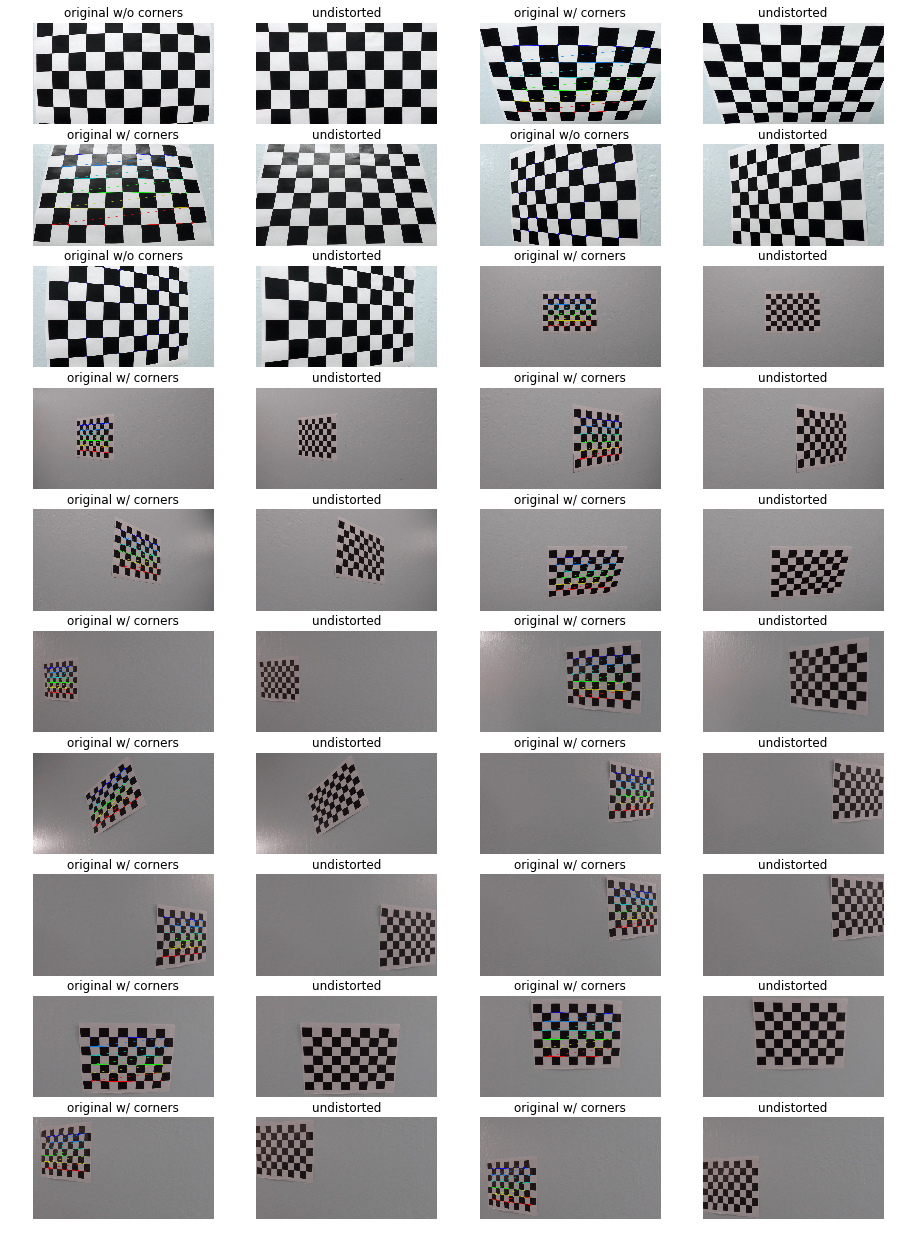

In [200]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates

# create output grid of plots
fig, axs = plt.subplots(10, 4, figsize=(16,22))
fig.subplots_adjust(hspace=0.2, wspace=0.001)
axs = axs.ravel()

# visualize chessboard images with corners detected
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
        axs[2*i].set_title('original w/ corners')
    else:
        axs[2*i].set_title('original w/o corners')

    axs[2*i].axis('off')
    axs[2*i].imshow(img)

# visualize undistorted versions of chessboard images
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undst = cv2.undistort(img, mtx, dist, None, mtx)

    axs[2*i+1].axis('off')
    axs[2*i+1].imshow(undst)
    axs[2*i+1].set_title('undistorted')
    
# NOTE: this is the point that `undistort(img)` was added to the list of 'Helper Functions'

## Apply Distortion Correction

In [668]:
# import the test image
test_img = cv2.imread(test_images[6])
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

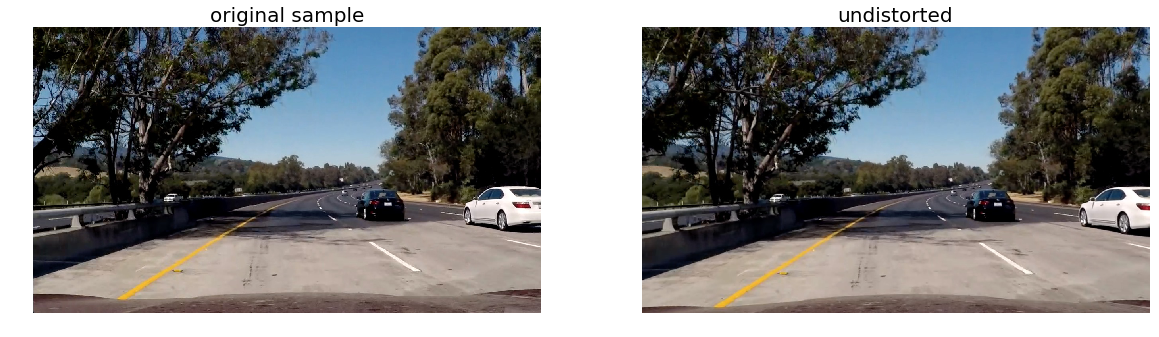

In [669]:
# apply undistortion to test image

if toggle:
    test_undst = undistort(test_img)
    f, axs = plt.subplots(1, 2, figsize=(20, 10))
    axs = axs.ravel()
    axs[0].axis('off')
    axs[0].imshow(test_img)
    axs[0].set_title('original sample', fontsize=20)
    axs[1].axis('off')
    axs[1].imshow(test_undst)
    axs[1].set_title('undistorted', fontsize=20)

Key Takeaway(s):
* the differences between the two images can be noticed in the varying car hood outline as well as the sizes and locations of objects in the distance

---

## Create Binary Image Using Perspective Transform

### Unwarping camera images

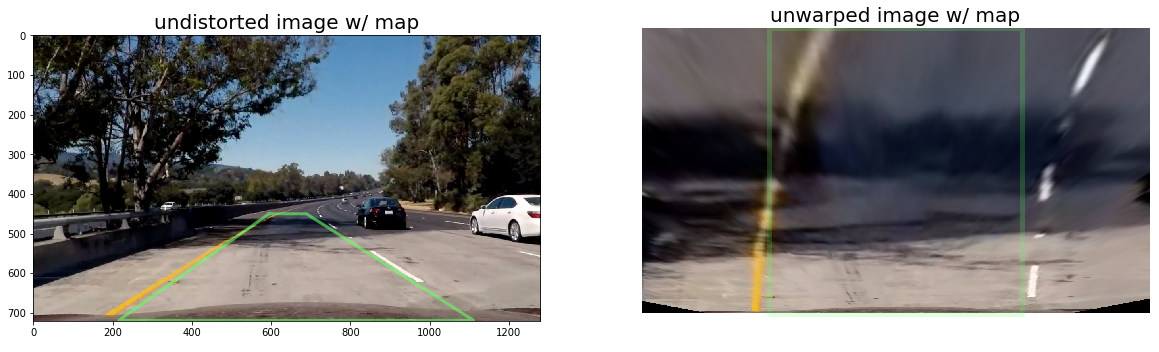

In [670]:
# determine src and dst coordinates for warping perspective
if toggle:
    img_h, img_w = test_img.shape[:2]

    # warp perspective
    M = cv2.getPerspectiveTransform(src, dst)
    test_unwarp = cv2.warpPerspective(test_undst, M, (img_w, img_h), flags=cv2.INTER_LINEAR)

    # visualize the unwarping
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

    # visualize source coordinates
    #ax1.axis('off')
    ax1.imshow(test_undst)
    ax1.plot(src_x, src_y, color='#66ff66', alpha=0.6, linewidth=3)
    ax1.set_title('undistorted image w/ map', fontsize=20)

    # visualize destination coordinates
    ax2.axis('off')
    ax2.imshow(test_unwarp)
    ax2.plot(dst_x, dst_y, color='#66ff66', alpha=0.2, linewidth=5)
    ax2.set_title('unwarped image w/ map', fontsize=20)

# NOTE: this is the point that `unwarp(img, src, dst)` was added to the list of 'Helper Functions'

Key Takeaway(s):
* if the camera is assumed to be in the center of the vehicle view, the asymmetry in the offset between the left lane and right lane can be used to determine vehicle lane positioning and orientation
* objects further away will have lower pixel resolution when unwarped

### Visualizing the image in various color spaces

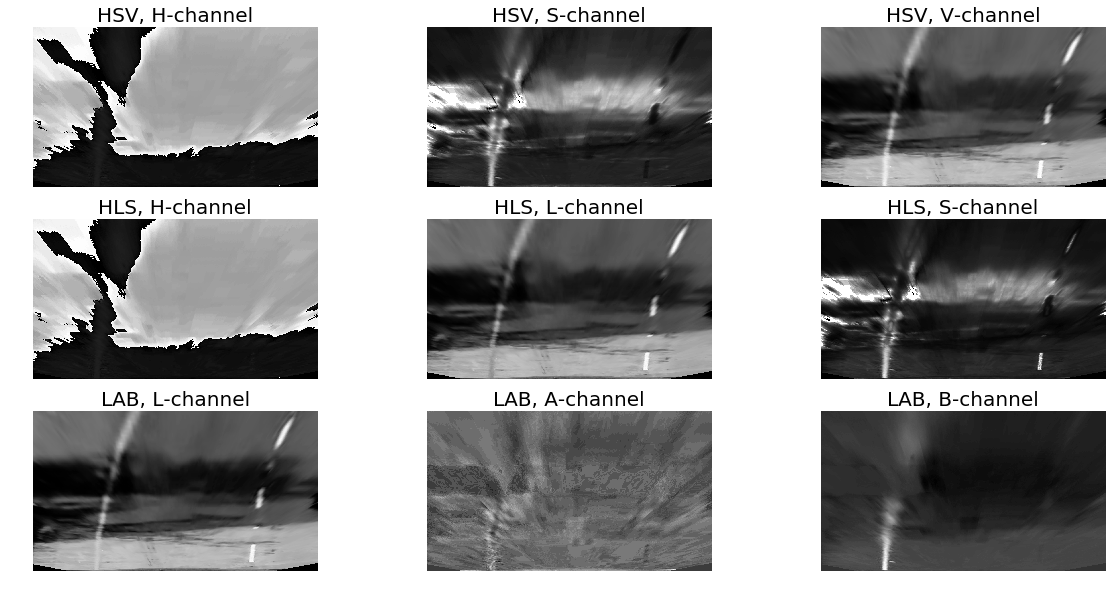

In [671]:
# HSV
if toggle:
    test_unwarpHSV = cv2.cvtColor(test_unwarp, cv2.COLOR_RGB2HSV)
    test_unwarpH = test_unwarpHSV[:,:,0]
    test_unwarpS = test_unwarpHSV[:,:,1]
    test_unwarpV = test_unwarpHSV[:,:,2]
    # HLS 
    test_unwarpHLS = cv2.cvtColor(test_unwarp, cv2.COLOR_RGB2HLS)
    test_unwarpH1 = test_unwarpHLS[:,:,0]
    test_unwarpL = test_unwarpHLS[:,:,1]
    test_unwarpS1 = test_unwarpHLS[:,:,2]
    # LAB
    test_unwarpLAB = cv2.cvtColor(test_unwarp, cv2.COLOR_RGB2Lab)
    test_unwarpL1 = test_unwarpLAB[:,:,0]
    test_unwarpA = test_unwarpLAB[:,:,1]
    test_unwarpB = test_unwarpLAB[:,:,2]

    visColors = [test_unwarpH, test_unwarpS, test_unwarpV,
                  test_unwarpH1, test_unwarpL, test_unwarpS1,
                  test_unwarpL1, test_unwarpA, test_unwarpB]

    visTitles = ['HSV, H-channel', 'HSV, S-channel', 'HSV, V-channel',
                'HLS, H-channel', 'HLS, L-channel', 'HLS, S-channel',
                'LAB, L-channel', 'LAB, A-channel', 'LAB, B-channel']

    f, axs = plt.subplots(3, 3, figsize=(20, 10))
    axs = axs.ravel()
    for i in range(len(visColors)):
        axs[i].axis('off')
        axs[i].imshow(visColors[i], cmap='gray')
        axs[i].set_title(visTitles[i], fontsize=20)

Key Takeaway(s):
* HSV H, HLS H, and LAB A channels lose detail of both lane lines
* HSV S, HLS L, and LAB B channels lose detail on the dotted white lane line
* HSV V, HLS S, and LAB L channels thus appear to be the best candidates for the combined binary image

### Visualizing the image in binarized colorspaces

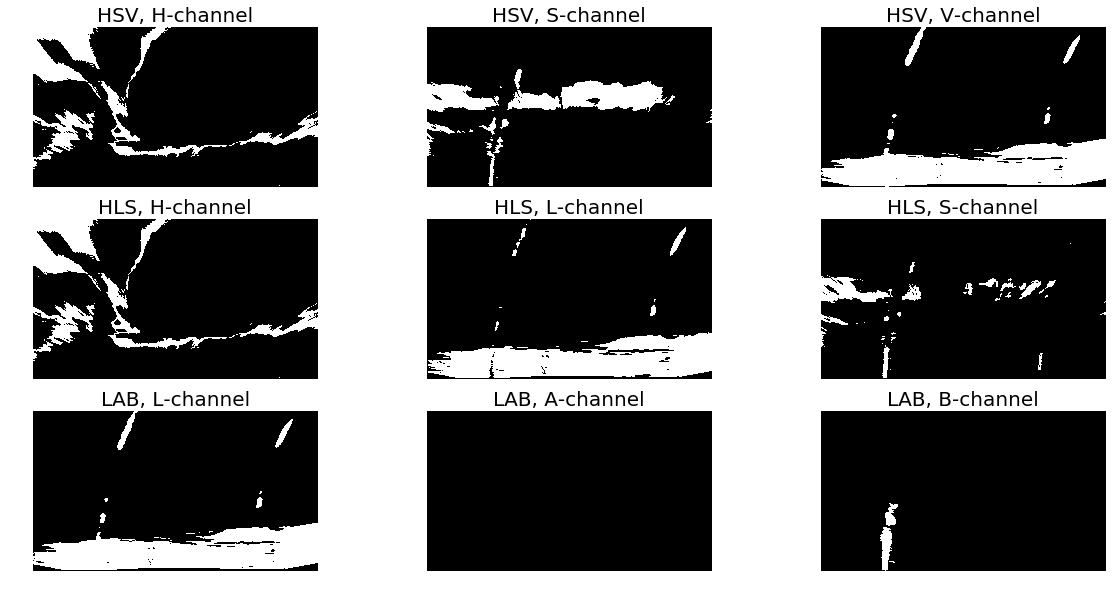

In [672]:
# NOTE: this is the point that binarize(img, thresh_min, thresh_max) is added to the list of 'Helper Functions'

if toggle:
    binColors = []

    f, axs = plt.subplots(3, 3, figsize=(20,10))
    axs = axs.ravel()
    for i in range(len(visColors)):
        binColors.append(binarize(visColors[i], thresh_min=150))
        axs[i].axis('off')
        axs[i].imshow(binColors[i], cmap='gray')
        axs[i].set_title(visTitles[i], fontsize=20)

Key Takeaway(s):
* for image `straight_lines1`, HSV V, HLS L, and LAB L channels seem to be most useful
* for image `test1`, HLS S and LAB B channels seem to be most useful
* considering using HSV V, HLS S and LAB B channel stack

### Visualizing the image by applying Sobel

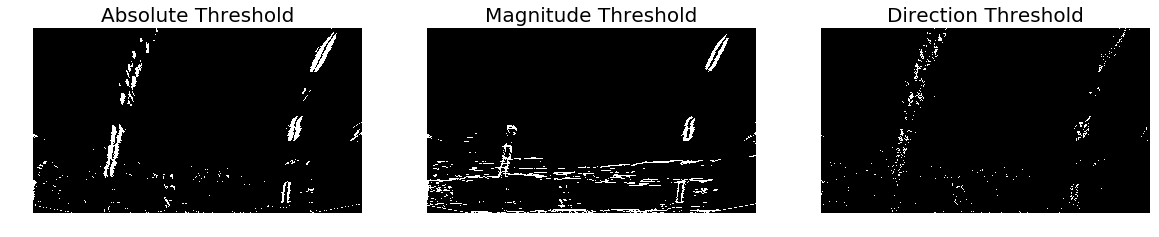

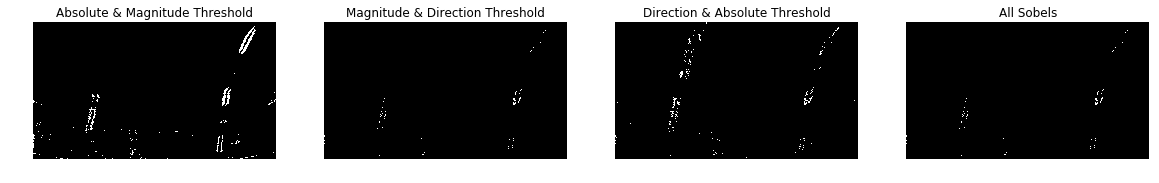

In [673]:
# NOTE: this is the point that all `sobel()` functions were added to the list of 'Helper Functions'

if toggle:
    test_unwarp_Sabs = abs_sobel_thresh(test_unwarp, thresh_min=15)
    test_unwarp_Smag = mag_thresh(test_unwarp, mag_thresh=(15,255))
    test_unwarp_Sdir = dir_threshold(test_unwarp, sobel_kernel=1, thresh=(0.01, 0.3))

    visSobels = [test_unwarp_Sabs,
                test_unwarp_Smag,
                test_unwarp_Sdir]

    visSobelTypes = ['Absolute Threshold',
                    'Magnitude Threshold',
                    'Direction Threshold']

    f, axs = plt.subplots(1, 3, figsize=(20, 10))
    axs = axs.ravel()

    for i in range(len(visSobels)):
        axs[i].axis('off')
        axs[i].imshow(visSobels[i], cmap='gray')
        axs[i].set_title(visSobelTypes[i], fontsize=20)

    f, axs = plt.subplots(1, 4, figsize=(20, 10))
    axs = axs.ravel()

    for i in range(3):
        axs[i].axis('off')
        axs[i].imshow(combined_binary(visSobels[i], visSobels[(i+1)%3]), cmap='gray')
        axs[i].set_title(visSobelTypes[i].split(' ')[0] + ' & ' + visSobelTypes[(i+1)%3])

    axs[3].axis('off')
    axs[3].imshow(combined_binary(combined_binary(visSobels[0], visSobels[1]), visSobels[2]), cmap='gray')
    axs[3].set_title('All Sobels')

Key Takeaway(s):
* each threshold appears to have various advantages. thus, it might be beneficial to incorporate all three

---

## Rectify Binary Image

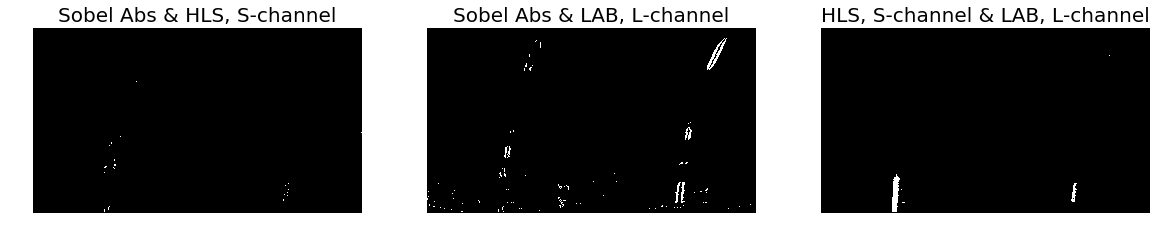

In [674]:
# NOTE: this is the point that `combined_binary` was added to the list of 'Helper Functions'

if toggle:
    test_Sabs_hlS = combined_binary(visSobels[0],binColors[5])
    test_Sabs_Lab = combined_binary(visSobels[0],binColors[6])
    test_hlS_Lab = combined_binary(binColors[5],binColors[6])

    combin = [test_Sabs_hlS,
              test_Sabs_Lab,
              test_hlS_Lab]

    combin_titles = ['Sobel Abs & HLS, S-channel',
                    'Sobel Abs & LAB, L-channel',
                    'HLS, S-channel & LAB, L-channel']

    f, axs = plt.subplots(1, 3, figsize=(20, 10))
    axs = axs.ravel()

    for i in range(len(combin)):
        axs[i].axis('off')
        axs[i].imshow(combin[i], cmap='gray')
        axs[i].set_title(combin_titles[i], fontsize=20)

Key Takeaway(s):
* combined HLS S-channel and LAB L-channel performs fairly consistently across various sample images

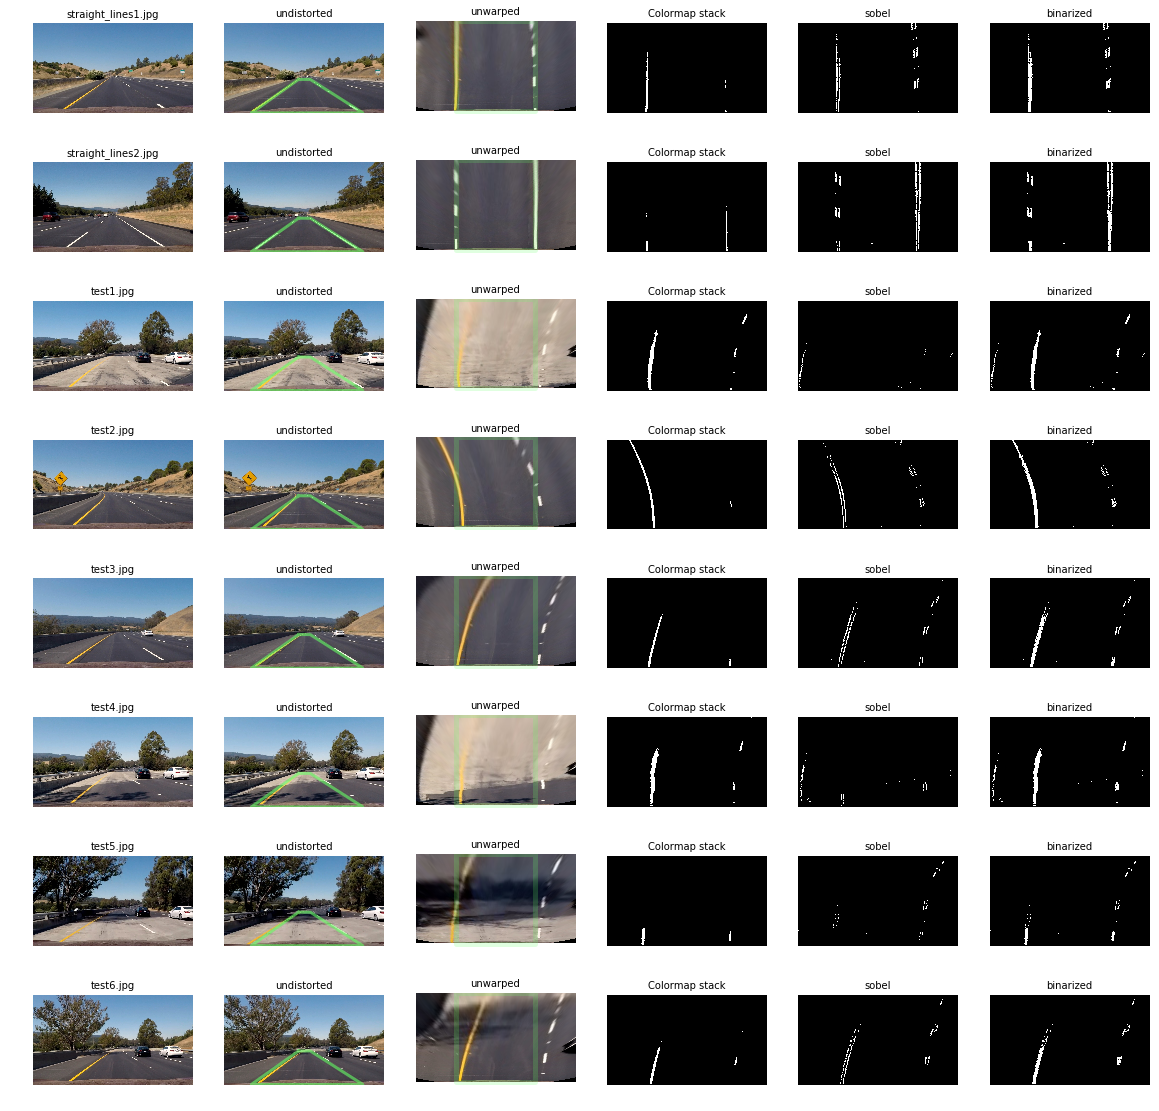

In [665]:
# test pipeline on all sample images
if toggle:
    images = glob.glob('test_images/*.jpg')
    n_rows = int(len(images))
    #n_rows = int(len(images)/2)
    n_cols = 6
    f, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))
    axs = axs.ravel()

    for i, fname in enumerate(images):
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        step1 = undistort(img)
        step2, Minv = unwarp(step1, src, dst)
        step3a1 = cv2.cvtColor(step2, cv2.COLOR_RGB2HLS)[:,:,2]
        step3a2 = cv2.cvtColor(step2, cv2.COLOR_RGB2Lab)[:,:,0]
        step3a = combined_binary(step3a1, step3a2, 'AND')
        step3b1 = abs_sobel_thresh(step2, thresh_min=15)
        step3b2  = mag_thresh(step2, mag_thresh=(15,255))
        step3b3 = dir_threshold(step2, thresh=(0.01, 0.4))
        step3b = combined_binary(step3b1, combined_binary(step3b2, step3b3))
        step4 = combined_binary(step3a, step3b, 'OR')
        
        axs[n_cols*i].axis('off')
        axs[n_cols*i].imshow(img)
        axs[n_cols*i].set_title(fname.split('/')[1], fontsize=10)
        axs[n_cols*i+1].axis('off')
        axs[n_cols*i+1].imshow(step1, cmap='gray')
        axs[n_cols*i+1].plot(src_x, src_y, color='#66ff66', alpha=0.6, linewidth=3)
        axs[n_cols*i+1].set_title('undistorted', fontsize=10)
        axs[n_cols*i+2].axis('off')
        axs[n_cols*i+2].imshow(step2, cmap='gray')
        axs[n_cols*i+2].plot(dst_x, dst_y, color='#66ff66', alpha=0.2, linewidth=5)
        axs[n_cols*i+2].set_title('unwarped', fontsize=10)
        axs[n_cols*i+3].axis('off')
        axs[n_cols*i+3].imshow(step3a, cmap='gray')
        axs[n_cols*i+3].set_title('Colormap stack', fontsize=10)
        axs[n_cols*i+4].axis('off')
        axs[n_cols*i+4].imshow(step3b, cmap='gray')
        axs[n_cols*i+4].set_title('sobel', fontsize=10)
        axs[n_cols*i+5].axis('off')
        axs[n_cols*i+5].imshow(step4, cmap='gray')
        axs[n_cols*i+5].set_title('binarized', fontsize=10)

# NOTE: this is the point that `pipeline` was added to the list of 'Helper Functions'  

## Detect Lane Pixels and Find Lane Boundary

In [637]:
count = 0

In [656]:
# Use the sliding window method to detect lane lines and their best fit 2nd order polynomial
def window_polyfit(img):
    h, w = img.shape
    
    # Adjustable parameters
    n_windows = 10 # the number of vertical windows used in detecting a lane
    marg_win = 100 # the number of horizontal pixels (each direction) in a window
    thres_pix = 100 # the min number of pixels needed to readjust window center
    
    # Set key mask parameters
    h_window = h // n_windows
    h_midpt = h // 2
    w_midpt = w // 2
    h_qtrpt = h // 4
    w_qtrpt = w // 4
    # Take a histogram of the bottom half of the image
    hist = np.sum(img[h_midpt:,:], axis=0)

    # Set left and right histogram peaks as window starting points (avoid outer lane lines)
    L_xBase = np.argmax(hist[:w_midpt]) # checks x-axis 2nd quarter
    R_xBase = w_midpt + np.argmax(hist[w_midpt:]) # checks x-axis 3rd quarter
    # Keep track of all potential lane line points
    nz = img.nonzero()
    nz_x, nz_y = np.array(nz[1]), np.array(nz[0])
    
    # Set initial window location
    L_xCurr = L_xBase
    R_xCurr = R_xBase
    # Initialize lists to store detected lane points
    L_idx = []
    R_idx = []
    window_idx = []
    
    # Determine window and lane line idx values
    for win in range(n_windows):
        # Calculate window locations
        win_yMax = h - win*h_window 
        win_yMin = h - (win+1)*h_window 
        winL_xMax = L_xCurr + marg_win
        winL_xMin = L_xCurr - marg_win
        winR_xMax = R_xCurr + marg_win
        winR_xMin = R_xCurr - marg_win
        window_idx.append((win_yMax, win_yMin, winL_xMax, winL_xMin, winR_xMax, winR_xMin))
        # Track nonzero points in window
        L_idxTemp = ((nz_y >= win_yMin) & (nz_y <= win_yMax) & (nz_x >= winL_xMin) & (nz_x <= winL_xMax)).nonzero()[0]
        R_idxTemp = ((nz_y >= win_yMin) & (nz_y <= win_yMax) & (nz_x >= winR_xMin) & (nz_x <= winR_xMax)).nonzero()[0]
        # Append these points to the detected lane points
        L_idx.append(L_idxTemp)
        R_idx.append(R_idxTemp)
        # Recalibrate starting position of next window according to points
        if len(L_idxTemp) > thres_pix:
            L_xCurr = np.int(np.mean(nz_x[L_idxTemp]))
        if len(R_idxTemp) > thres_pix:
            R_xCurr = np.int(np.mean(nz_x[R_idxTemp]))
            
    # Concatenate arrays
    L_idx = np.concatenate(L_idx)
    R_idx = np.concatenate(R_idx)
    # Extract lane lines points
    L_x = nz_x[L_idx]
    L_y = nz_y[L_idx]
    R_x = nz_x[R_idx]
    R_y = nz_y[R_idx]
    
    L_poly, R_poly = (None, None)
    if len(L_x) != 0:
        L_poly = np.polyfit(L_y, L_x, 2)
    if len(R_x) != 0:
        R_poly = np.polyfit(R_y, R_x, 2)
        
    return L_poly, R_poly, L_idx, R_idx, window_idx, hist

In [657]:
# Calculate radius of curvature and vehicle position
def calc_radius_position(leftPoly, rightPoly, leftIdx, rightIdx):
    # Image height, width
    h = 720
    w = 1280
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/h # meters per pixel in y dimension
    xm_per_pix = 3.7/(w/2) # meters per pixel in x dimension
    
    # Define lane lines
    ploty = np.linspace(0, h-1, num=h)
    leftx = leftPoly[0]*ploty**2 + leftPoly[1]*ploty + leftPoly[2]
    rightx = rightPoly[0]*ploty**2 + rightPoly[1]*ploty + rightPoly[2]
    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print("left rad: {} m, right rad: {} m,".format(left_curverad, right_curverad))
    
    # Calculate position from center based on base values of {L, R} polynomials
    center_pos = xm_per_pix * ((rightx[h-1] + leftx[h-1])/2 - w/2)
    print("distance from center: {} m".format(center_pos))

    ############################################################
    
    return leftx, rightx, left_curverad, right_curverad, center_pos

53625.6800023 25287.750432
left rad: 689.1592939101711 m, right rad: 344.8380633410517 m,
distance from center: -0.025649684714610183 m


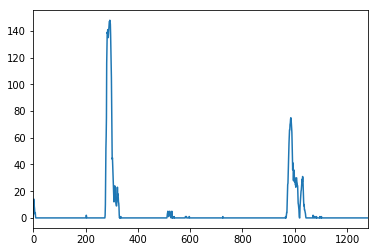

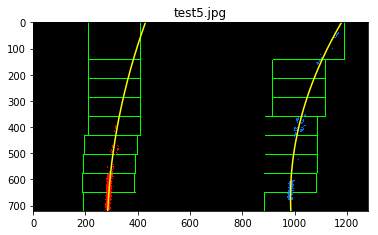

In [664]:
# NOTE: this is the point that `window_polyfit` was added to the list of 'Helper Functions'

# Visualize the result on sample image
test_imgFname = test_images[count % 8]
count += 1
test_img = cv2.imread(test_imgFname)
#print(test_img.shape)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_imgP, Minv = pipeline(test_img)

h, w, _ = test_img.shape
test_imgD = np.uint8(np.dstack((test_imgP, test_imgP, test_imgP)))

L_poly, R_poly, L_idx, R_idx, wind, hist = window_polyfit(test_imgP)
'''
# Calculate the points of lane polynomials to plot
LR_y = np.linspace(0, h-1, h)
L_x = L_poly[0]*LR_y**2 + L_poly[1]*LR_y + L_poly[2]
R_x = R_poly[0]*LR_y**2 + R_poly[1]*LR_y + R_poly[2]
'''
L_x, R_x, L_rad, R_rad, center = calc_radius_position(L_poly, R_poly, L_idx, R_idx)
# Add the rectangles to the image
for w in wind:
    cv2.rectangle(test_imgD, (w[2], w[0]), (w[3], w[1]), [0, 255, 0], 2)
    cv2.rectangle(test_imgD, (w[4], w[0]), (w[5], w[1]), [0, 255, 0], 2)
        
# Identify the detected lane pixels
nz = test_imgP.nonzero()
nz_x, nz_y = np.array(nz[1]), np.array(nz[0])
test_imgD[nz_y[L_idx], nz_x[L_idx]] = [255, 0, 0]
test_imgD[nz_y[R_idx], nz_x[R_idx]] = [0, 100, 255]

# Extend 



# VISUALIZATION

# Print histogram from sliding window polyfit for example image
plt.figure()
plt.plot(hist)
plt.xlim(0, 1280)

# Show identified lanes
plt.figure()
plt.imshow(test_imgD)
plt.plot(L_x, LR_y, color='yellow')
plt.plot(R_x, LR_y, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.title(test_imgFname.split('/')[1])

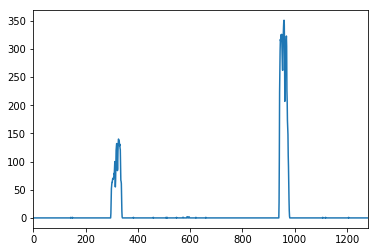

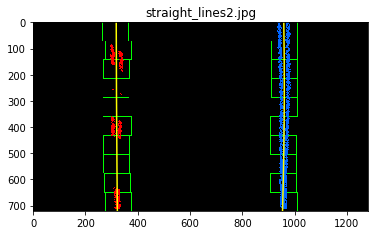

In [641]:
# NOTE: this is the point that `window_polyfit` was added to the list of 'Helper Functions'

# Visualize the result on sample image
test_imgFname = test_images[count % 8]
count += 1
test_img = cv2.imread(test_imgFname)
#print(test_img.shape)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_imgP, Minv = pipeline(test_img)

h, w, _ = test_img.shape
test_imgD = np.uint8(np.dstack((test_imgP, test_imgP, test_imgP)))

L_poly, R_poly, L_idx, R_idx, wind, hist = window_polyfit(test_imgP)
# Calculate the points of lane polynomials to plot
LR_y = np.linspace(0, h-1, h)
L_x = L_poly[0]*LR_y**2 + L_poly[1]*LR_y + L_poly[2]
R_x = R_poly[0]*LR_y**2 + R_poly[1]*LR_y + R_poly[2]
    
# Add the rectangles to the image
for w in wind:
    cv2.rectangle(test_imgD, (w[2], w[0]), (w[3], w[1]), [0, 255, 0], 2)
    cv2.rectangle(test_imgD, (w[4], w[0]), (w[5], w[1]), [0, 255, 0], 2)
        
# Identify the detected lane pixels
nz = test_imgP.nonzero()
nz_x, nz_y = np.array(nz[1]), np.array(nz[0])
test_imgD[nz_y[L_idx], nz_x[L_idx]] = [255, 0, 0]
test_imgD[nz_y[R_idx], nz_x[R_idx]] = [0, 100, 255]

# Extend 



# VISUALIZATION

# Print histogram from sliding window polyfit for example image
plt.figure()
plt.plot(hist)
plt.xlim(0, 1280)

# Show identified lanes
plt.figure()
plt.imshow(test_imgD)
plt.plot(L_x, LR_y, color='yellow')
plt.plot(R_x, LR_y, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title(test_imgFname.split('/')[1])

In [ ]:
# Refine the polynomial lines
# compare points between L and R lane lines



---

## Determine Lane Curvature and Vehicle Position

---

## Warp Lane Boundary Onto Image

---

## Display Final Image and Output Metrics

---